## Predicting house prices
This data set was downloaded from [this](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) Kaggle competition.
Multiple models are implemented in this notebook.

In [8]:
import tensorflow as tf
tf.add(1,2).numpy()
hello = tf.constant('Hello, TensorFlow!')
hello.numpy()

b'Hello, TensorFlow!'

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

In [10]:
df = pd.read_csv('data/train.csv')
print("The dataset shape is {}".format(df.shape))

The dataset shape is (1460, 81)


The houses dataset contains 80 columns and 1459 rows. Let's look at the first three rows:

In [11]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Two preliminary obvervations are:
1. The Id label is useless for predicting purposes, thus drop from dataset.
2. The target variable is the SalePrice

To drop Id column:

In [12]:
df = df.drop('Id', axis=1)
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Types of feature columns:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

A preliminary observation. One could drop the following columns: PoolQC, MiscFeature, and Alley, since a very small amount of records contain data for these. We will keep them and adapt the preprocessing to handle null values.

#### House Prices Distribution

In [14]:
house_prices = df['SalePrice']
house_prices.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The average and median sale price are 180,921 and 163,000, respectively.

In [15]:
plt.figure(figsize=(16,8))
sns.histplot(df['SalePrice'], color='g', bins=100);

NameError: name 'sns' is not defined

<Figure size 1152x576 with 0 Axes>

In [16]:
list(set(df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

Let's analyze the distribution of the numerical features

In [17]:
num_df = df.select_dtypes(include=['int64', 'float64'])
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

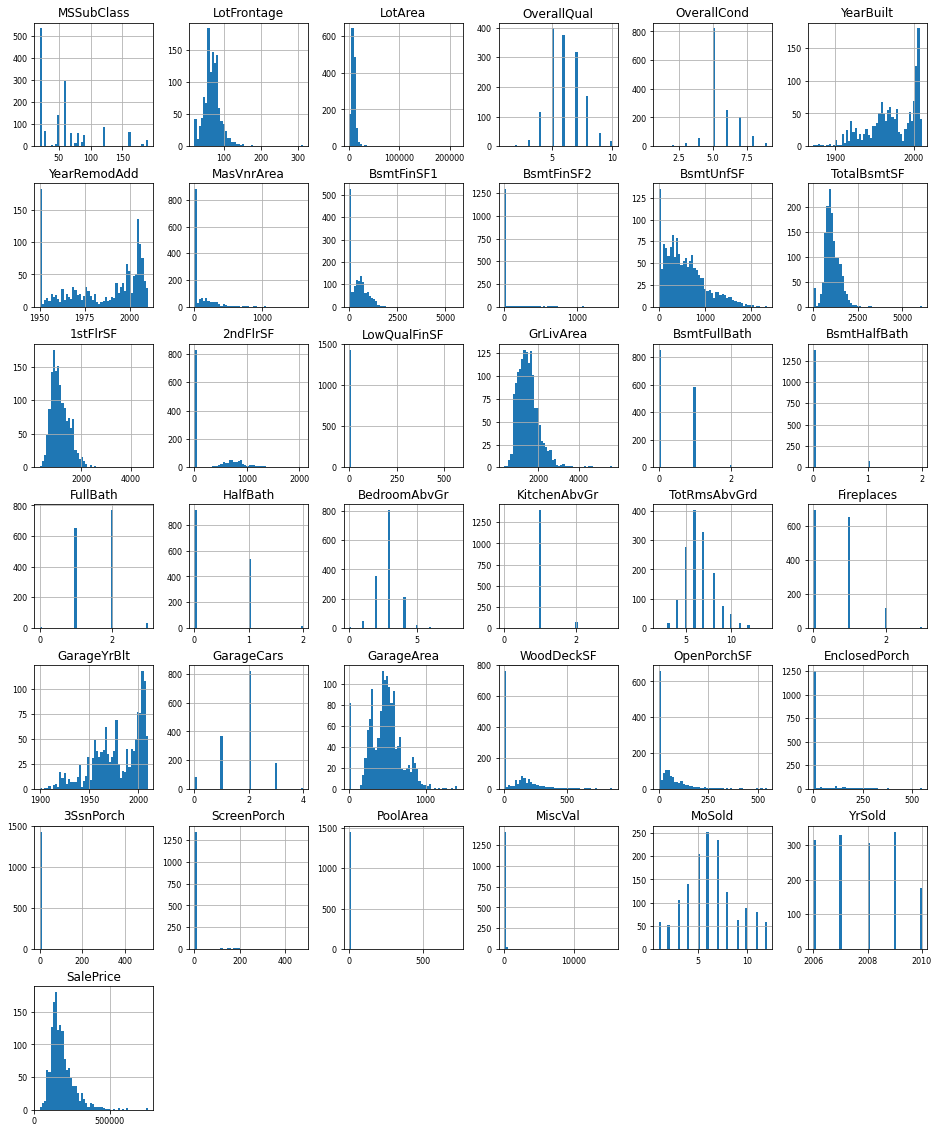

In [18]:
import tensorflow as tf

num_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [21]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1045 examples in training, 415 examples in testing.


In [22]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [24]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [28]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /var/folders/fb/1t5484hs7hx0m350w85ylr280000gn/T/tmpo9h7jlhu as temporary training directory


In [30]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.036490. Found 1045 examples.
Training model...
Model trained in 0:00:00.471979
Compiling model...


[INFO 23-11-05 22:15:26.3253 PST kernel.cc:1233] Loading model from path /var/folders/fb/1t5484hs7hx0m350w85ylr280000gn/T/tmpo9h7jlhu/model/ with prefix bda3a50ab3154ae6
[INFO 23-11-05 22:15:26.4433 PST decision_forest.cc:660] Model loaded with 300 root(s), 99320 node(s), and 74 input feature(s).
[INFO 23-11-05 22:15:26.4434 PST kernel.cc:1061] Use fast generic engine


Model compiled.


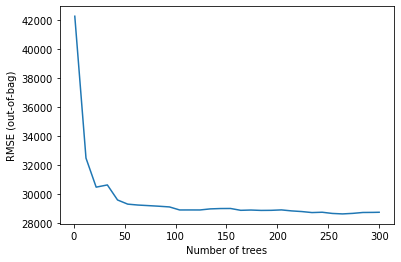

In [38]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [40]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 114ms/step - loss: 0.0000e+00 - mse: 993708416.0000
loss: 0.0000
mse: 993708416.0000


In [43]:
inspector = rf.make_inspector()
inspector.evaluation()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [45]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 113.0),
 ("ExterQual" (4; #22), 65.0),
 ("Neighborhood" (4; #59), 39.0),
 ("GarageCars" (1; #32), 19.0),
 ("GrLivArea" (1; #38), 18.0),
 ("YearBuilt" (1; #76), 15.0),
 ("GarageArea" (1; #31), 12.0),
 ("KitchenQual" (4; #44), 8.0),
 ("BsmtQual" (4; #14), 4.0),
 ("TotalBsmtSF" (1; #73), 4.0),
 ("GarageYrBlt" (1; #37), 2.0),
 ("GarageFinish" (4; #34), 1.0)]

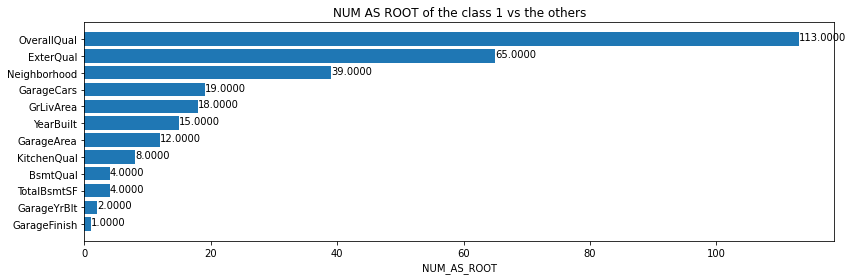

In [47]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()